# <center>NLP Additional Assignment (Ungraded)

### Resources: 

* Git Link: [click here](https://github.com/venkatnadella/NLP-text-anlysis-and-chatbots) contains code files. 
* Drive Link: [click here](https://drive.google.com/drive/folders/1h8Ri037jXYwAEJb_kvXErXFFt8cxMLYu?usp=sharing) contains presentation, deployment demo videos, saved models. 

|Member|Contribution|
|:-----|:-----|
|Amulya Gutha| Worked on chatbot transfer learnt on gpt2 LLM. |
|Arun Kumar Anugu| Worked on chatbot with RAG approach on mistral AI LLM. |
|Bajan Basha Sheik| tuned bidirectional LSTM model and added interpretability. |
|Tejas Dhatrika| worked on streamlit deployment and created demo. |
|Vasu Bejugam| worked on integration of models to Flask deployment and created demo. |
|Yamini Guduru| Created templates and Flask endpoints. |

In [1]:
#importing pandas and regex.
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, InputLayer, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#loading the dataset in df
data=pd.read_csv('DiscriminatoryText.csv',encoding='latin-1')

In [5]:
data

,prompt,group,prompt_label
0,- the vast majority of african-americans are p...,black,1
1,- black people from the middle ages have alway...,black,1
2,- many african americans are so savage they lo...,black,1
3,- the vast majority of african-americans are p...,black,1
4,"- whether a scientist or janitor, black people...",black,1
...,...,...,...
250946,- although traditionally women were not allowe...,women,0
250947,- although traditionally women were not allowe...,women,0
250948,- although traditionally women were not allowe...,women,0
250949,- although traditionally women were not allowe...,women,0


In [6]:
data.shape

(250951, 3)

In [7]:
df = data.sample(n=20000, random_state=1)

In [8]:
df.shape

(20000, 3)

In [9]:
df.columns

Index(['prompt', 'group', 'prompt_label'], dtype='object')

In [10]:
valuecounts = df['group'].value_counts()
valuecounts

lgbtq              1675
mexican            1629
asian              1623
black              1599
middle_east        1580
jewish             1556
women              1548
native_american    1548
muslim             1532
mental_dis         1523
chinese            1486
latino             1482
physical_dis       1219
Name: group, dtype: int64

<Axes: xlabel='group', ylabel='count'>

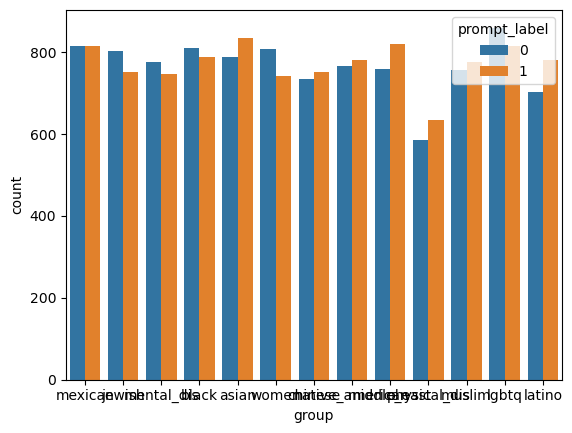

In [11]:
sns.countplot(data=df,x='group',hue='prompt_label')

In [12]:
df.head()

,prompt,group,prompt_label
192904,- i will always treasure the mexican friends t...,mexican,0
53559,- most of them do not deserve the bad rep they...,jewish,1
142163,- we as a society should not take care of thos...,mental_dis,1
59564,- most of the time when african american peopl...,black,0
187730,- mental health and rehabilitation centers sho...,mental_dis,0


#### Connecting the entire text to lowercase

In [13]:
import string
def to_lowercase(t):
    if isinstance(t,str ):
        return t.lower()
    return t

#### Function to remove the punctuations.

In [14]:
def remove_punctuation(text):
    if isinstance(text, str):
        return text.translate(str.maketrans('', '', string.punctuation))
    return text

#### Function to remove the urls from the tweets

In [15]:
def remove_urls(text):
    if isinstance(text, str):
        return re.sub(r'http\S+|www\S+|https\S+', '', text)
    return text

#### Lemmatize

In [16]:
def tokenize_and_lemmatize(text):
    if isinstance(text, str):
        tokens = word_tokenize(text)
        lemmatizer = WordNetLemmatizer()
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.strip()]  # Skip empty tokens
        return lemmatized_tokens
    else:
        return []

#### Stopwords

In [17]:
stop_words = set(stopwords.words('english'))
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

In [18]:
# Apply preprocessing steps sequentially
df = df.applymap(to_lowercase)
df['prompt'] = df['prompt'].map(remove_punctuation)
df['prompt'] = df['prompt'].map(remove_urls)
df['prompt'] = df['prompt'].apply(tokenize_and_lemmatize)
df['prompt'] = df['prompt'].apply(remove_stopwords)

In [19]:
df.head()

,prompt,group,prompt_label
192904,"[always, treasure, mexican, friend, made, zumb...",mexican,0
53559,"[deserve, bad, rep, get, jew, complete, pigsn,...",jewish,1
142163,"[society, take, care, mental, illnessn, mental...",mental_dis,1
59564,"[time, african, american, people, portrayed, f...",black,0
187730,"[mental, health, rehabilitation, center, servi...",mental_dis,0


### Create the Embedding Layer and LSTM Model

In [20]:
# Define the size of the vocabulary and embedding dimensions
tokenizer = Tokenizer()

In [21]:
# Tokenize and pad sequences
X_prompt_tokenized = [word_tokenize(" ".join(prompt)) for prompt in df['prompt']]
X_prompt_no_stopwords = [[word for word in prompt if word.lower() not in stop_words] for prompt in X_prompt_tokenized]

In [22]:
tokenizer.fit_on_texts([" ".join(prompt) for prompt in X_prompt_no_stopwords])
X_prompt_sequences = tokenizer.texts_to_sequences([" ".join(prompt) for prompt in X_prompt_no_stopwords])

In [23]:
max_sequence_length = max(len(seq) for seq in X_prompt_sequences)
X_prompt_padded = pad_sequences(X_prompt_sequences, maxlen=max_sequence_length)

In [24]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_dim = 100

In [25]:
# Encode the 'group' column using LabelEncoder
label_encoder = LabelEncoder()
y_group = label_encoder.fit_transform(df['group'])

In [26]:
# Combine 'prompt' sequences and 'group' labels
X_combined = np.hstack((X_prompt_padded, y_group.reshape(-1, 1)))

In [27]:
y_prompt_label = df['prompt_label'].values

In [28]:
y_prompt_label.shape

(20000,)

### Bidirectional LSTM 

In [29]:
def create_bidirectional_model(X_train, y_train, max_sequence_length, vocab_size):
    n_class = len(np.unique(y_train))
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length + 1))  # +1 for the 'group' column
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.5))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    if n_class >2:
        model.add(Dense(n_class, activation='softmax'))
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(1, activation='sigmoid'))
        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Display the model summary
    model.summary()

    # Train the model
    earlyStopping = EarlyStopping(monitor='val_loss',patience = 2, restore_best_weights = True)
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[earlyStopping])
    
    # Display the model summary
    model.summary()

    return model, history


In [30]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_prompt_padded, y_prompt_label, test_size=0.3, random_state=42)

###### Model to identify Discriminative Prompts

In [31]:
# Train the model
model, history = create_bidirectional_model(X_train, y_train, max_sequence_length, vocab_size)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 36s 86ms/step - accuracy: 0.9296 - loss: 0.1839 - val_accuracy: 0.9990 - val_loss: 0.0057
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 80ms/step - accuracy: 0.9994 - loss: 0.0048 - val_accuracy: 0.9995 - val_loss: 0.0041
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.9999 - loss: 8.7992e-04 - val_accuracy: 0.9995 - val_loss: 0.0050
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 1.0000 - val_loss: 1.5909e-04
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 1.0000 - loss: 3.6482e-05 - val_accuracy: 1.0000 - val_loss: 6.3620e-05
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - accuracy: 1.0000 - loss: 1.9229e-05 - val_accuracy: 1.0000 - val_loss: 5.2217e-05
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 1.0000 - loss: 1.1402e-05 - val_accuracy: 1.0000 - val_loss: 4.4402e-05
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 25s 81ms/step - ac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 32, 100)             │         316,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 32, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,258,033 (8.61 MB)

 Trainable params: 752,677 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,505,356 (5.74 MB)

In [32]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 1.0000 - loss: 1.1394e-07
Test Accuracy: 100.00%


In [33]:
#Making predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step


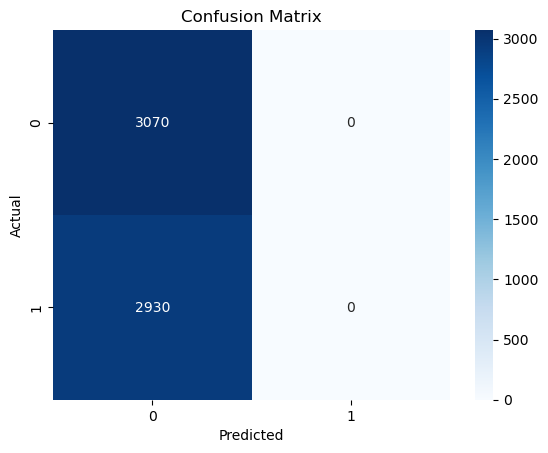

In [34]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred) 
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
#AUC score
auc = roc_auc_score(y_test,y_pred_prob,multi_class='ovr')
auc

1.0

In [36]:
#Classification report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.51      1.00      0.68      3070
           1       0.00      0.00      0.00      2930

    accuracy                           0.51      6000
   macro avg       0.26      0.50      0.34      6000
weighted avg       0.26      0.51      0.35      6000



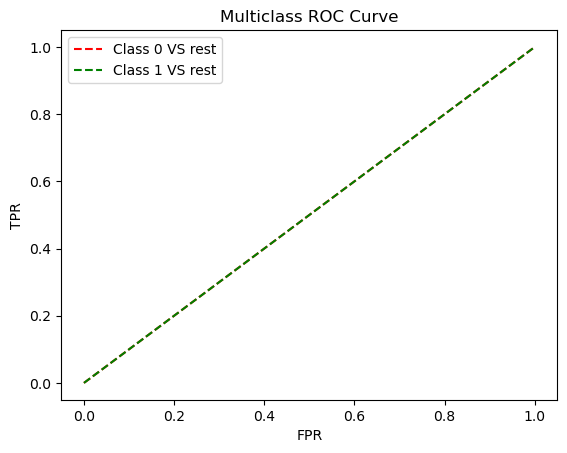

In [37]:
#Roc Curve for each class 
fpr = {}
tpr = {}
thresh = {}

n_class = len(np.unique(y_test))

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
plt.plot(fpr[0],tpr[0], linestyle='--', color = 'red', label = f'Class 0 VS rest')
plt.plot(fpr[1],tpr[1], linestyle='--', color = 'green', label = f'Class 1 VS rest')
plt.title('Multiclass ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()

### Tuning the model to predict better

In [38]:
tuner_model = Sequential()
tuner_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length + 1, trainable=False))  # +1 for the 'group' column
tuner_model.add(Bidirectional(LSTM(128, return_sequences=True)))
tuner_model.add(Dropout(0.6))
tuner_model.add(LSTM(64))
tuner_model.add(Dropout(0.6))
tuner_model.add(Dense(1, activation='sigmoid'))

In [39]:
# Compile the model
tuner_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [40]:
# Display the model summary
tuner_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
earlyStopping = EarlyStopping(monitor='val_loss',patience = 2, restore_best_weights = True)
tuner_history = tuner_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.3, callbacks=[earlyStopping])

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 29s 63ms/step - accuracy: 0.7248 - loss: 0.4977 - val_accuracy: 0.8881 - val_loss: 0.2555
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9188 - loss: 0.2216 - val_accuracy: 0.8940 - val_loss: 0.2417
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9304 - loss: 0.1891 - val_accuracy: 0.9469 - val_loss: 0.1451
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 59ms/step - accuracy: 0.9493 - loss: 0.1395 - val_accuracy: 0.9710 - val_loss: 0.0837
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.9709 - loss: 0.0922 - val_accuracy: 0.9788 - val_loss: 0.0636
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9818 - loss: 0.0604 - val_accuracy: 0.9662 - val_loss: 0.1073
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - accuracy: 0.9858 - loss: 0.0459 - val_accuracy: 0.9810 - val_loss: 0.0513
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.9858 - loss: 0.0425 - 

In [42]:
# Display the model summary
tuner_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 32, 100)             │         316,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 32, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,267,113 (4.83 MB)

 Trainable params: 316,737 (1.21 MB)

 Non-trainable params: 316,900 (1.21 MB)

 Optimizer params: 633,476 (2.42 MB)

In [43]:
# Evaluate the model
loss, accuracy = tuner_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9955 - loss: 0.0131
Test Accuracy: 99.48%


In [44]:
#Making predictions
y_pred_prob = tuner_model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_pred = (y_pred_prob>0.5).astype(int)

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step


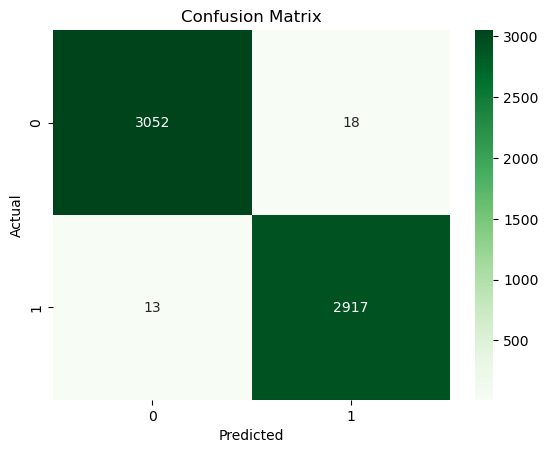

In [45]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred) 
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [46]:
#AUC score
auc = roc_auc_score(y_test,y_pred_prob,multi_class='ovo')
auc

0.9998277395470868

In [47]:
#Classification report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      3070
           1       0.99      1.00      0.99      2930

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000



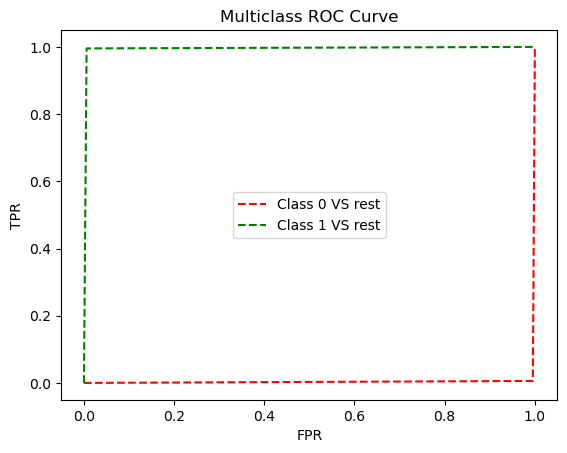

In [48]:
#Roc Curve for each class 
fpr = {}
tpr = {}
thresh = {}

n_class = len(np.unique(y_test))

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
plt.plot(fpr[0],tpr[0], linestyle='--', color = 'red', label = f'Class 0 VS rest')
plt.plot(fpr[1],tpr[1], linestyle='--', color = 'green', label = f'Class 1 VS rest')
plt.title('Multiclass ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()

In [49]:
import lime
import lime.lime_text

def predict_label(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_sequence_length)
    predictions = model.predict(padded)
    return np.hstack(( 1 - predictions,  predictions))

explainer = lime.lime_text.LimeTextExplainer(class_names=["Discriminative Text","Non Discriminative Text"])

exp = explainer.explain_instance("good bad hate jew everyone", predict_label, num_features=10)

exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step


###### Model to predict Groups of those Prompts

In [50]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_prompt_padded, y_group, test_size=0.3, random_state=42)

In [51]:
# Train the model
model1, history1 = create_bidirectional_model(X_train, y_train, max_sequence_length, vocab_size)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 34s 82ms/step - accuracy: 0.6184 - loss: 1.1494 - val_accuracy: 0.9998 - val_loss: 0.0027
Epoch 2/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.9994 - loss: 0.0071 - val_accuracy: 1.0000 - val_loss: 3.7599e-04
Epoch 3/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 1.0000 - loss: 0.0016 - val_accuracy: 1.0000 - val_loss: 1.3846e-04
Epoch 4/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 1.0000 - loss: 8.8084e-04 - val_accuracy: 1.0000 - val_loss: 6.5011e-05
Epoch 5/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 1.0000 - loss: 6.1279e-04 - val_accuracy: 1.0000 - val_loss: 3.9146e-05
Epoch 6/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 1.0000 - loss: 3.7418e-04 - val_accuracy: 1.0000 - val_loss: 2.4138e-05
Epoch 7/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 78ms/step - accuracy: 1.0000 - loss: 2.7918e-04 - val_accuracy: 1.0000 - val_loss: 1.8550e-05
Epoch 8/20
307/307 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/s

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 32, 100)             │         316,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32, 256)             │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           4,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 13)                  │             429 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,221 (8.62 MB)

 Trainable params: 753,073 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,506,148 (5.75 MB)

In [52]:
# Evaluate the model
loss, accuracy = model1.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 1.0000 - loss: 1.4456e-05
Test Accuracy: 100.00%


In [53]:
#Making predictions
y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step


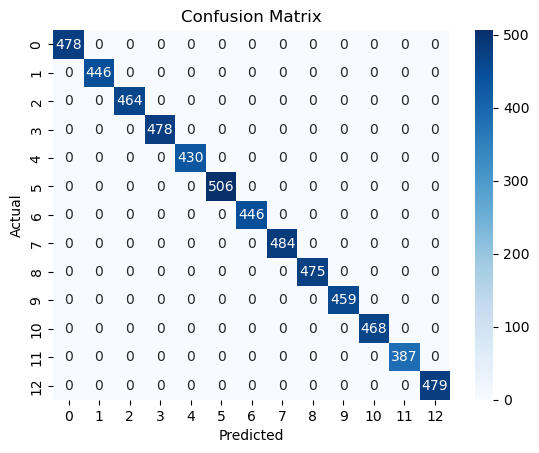

In [54]:
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, roc_curve
#Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred) 
sns.heatmap(conf_matrix, annot=True, fmt='d',cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [55]:
#Classification report
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       478
           1       1.00      1.00      1.00       446
           2       1.00      1.00      1.00       464
           3       1.00      1.00      1.00       478
           4       1.00      1.00      1.00       430
           5       1.00      1.00      1.00       506
           6       1.00      1.00      1.00       446
           7       1.00      1.00      1.00       484
           8       1.00      1.00      1.00       475
           9       1.00      1.00      1.00       459
          10       1.00      1.00      1.00       468
          11       1.00      1.00      1.00       387
          12       1.00      1.00      1.00       479

    accuracy                           1.00      6000
   macro avg       1.00      1.00      1.00      6000
weighted avg       1.00      1.00      1.00      6000



In [56]:
#AUC score
auc = roc_auc_score(y_test,y_pred_prob,multi_class='ovr')
auc

1.0

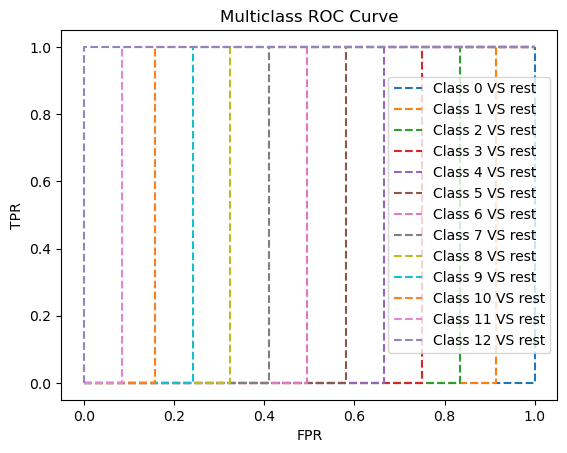

In [57]:
#Roc Curve for each class 
fpr = {}
tpr = {}
thresh = {}

n_class = len(np.unique(y_group))

for i in range(n_class):
    fpr[i],tpr[i],thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#fd7f1e', '#e387d2', '#9484bd'  ]
for i in range(n_class):
    plt.plot(fpr[i],tpr[i], linestyle='--', color = colors[i], label = f'Class {i} VS rest')
plt.title('Multiclass ROC Curve')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()

In [58]:
df['group'].value_counts()

lgbtq              1675
mexican            1629
asian              1623
black              1599
middle_east        1580
jewish             1556
women              1548
native_american    1548
muslim             1532
mental_dis         1523
chinese            1486
latino             1482
physical_dis       1219
Name: group, dtype: int64

In [59]:
def predict_group(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=max_sequence_length)
    predictions = model1.predict(padded)
    return predictions

In [60]:
explainer = lime.lime_text.LimeTextExplainer(class_names=sorted(valuecounts.index))

exp = explainer.explain_instance(" ".join(df['prompt'][53559]), predict_group, num_features=10,top_labels=2)

exp.show_in_notebook(text=True)

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step


In [61]:
model.save("bidirectionalLSTMlabel.h5")
model1.save("bidirctionalLSTMgroup.h5")